# Task 2: Recurrent Attention Model (RAM)

Reference: https://papers.nips.cc/paper/5542-recurrent-models-of-visual-attention.pdf

Useful links:
https://medium.com/towards-data-science/visual-attention-model-in-deep-learning-708813c2912c

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

print("number of training samples: ", mnist.train.num_examples)
print("number of validation samples: ", mnist.validation.num_examples)
print("number of test samples: ", mnist.test.num_examples)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
number of training samples:  55000
number of validation samples:  5000
number of test samples:  10000


## Task 2, Part 1: RAM networks

Recurrent attention model (RAM) is a model which processes inputs sequentially. For example, in the image classification problem, rather than using the whole image as input, RAM only takes a look at the small patch of the image at each step. RAM itself can learn what/where it should pay attention to, depending on which task it is executing. The core network consists of three parts: **glimpse net**, **rnn net**, and **location net/action net**. 

As shown in the following figure, 

* Glimpse Net: shown in A) and B) in the figure. It includes a glimpse sensor which extracts a small patch from the original image, and a glimpse net which combines both glimpse info and location info together with fully connected network and $g_t$ output vector.

* RNN Net: takes $g_t$ as input, passes it through a one-layer rnn network, and outputs the hidden states $h_t$ of the rnn cell.

* Location Net: uses $h_t$ to estimate the next location $l_t$ for the glimpse.

* Action/Classification Net: uses the last $h_t$ set as features to classify the label of a digit image.

* At each step, $l_t$ is fed back to the glimpse net, to get the next $g_{t+1}$ for the RNN, as shown in C).

![ram](./img/whole_net.png)

### step 1: Glimpse network

<span style="color:red">TODO:</span> Complete **glimpse_sensor**, and **\__call__** functions of the **GlimpseNet class** in the **ecbm4040/ram/networks.py**.

* Glimpse sensor/Retina and location encodings: The retina encoding ρ(x, l) extracts k square patches centered at location l, with the first patch being [glimpse_win × glimpse_win] pixels in size, and each successive patch having twice the width of the previous. The k patches are then all resized to [glimpse_win, glimpse_win] and concatenated. Glimpse locations l were encoded as real-valued (x, y) coordinates with (0, 0) being the center of the image x, and (−1, −1) being the top left corner of x. So the value of x or y is between -1 and 1.

* Glimpse net: it is one kind of a MLP network.
  * $hl = ReLU( Linear(l) )$
  * $hg = ReLU(Linear(ρ(x, l)))$
  * $g = ReLU(Linear(hl) + Linear(hg))$

![glimpse_net](./img/glimpse_net.png)

### step 2: Location network

<span style="color:red">TODO:</span> Finish **\__call__** function of **LocNet class** in **ecbm4040/ram/networks.py**.

* Location net:
  * ${E}[l_t] = Linear(h_t)$
  * Gaussian stochastic policy: $l_t \sim N(E[l_t], \sigma^2)$, next location for glimpse is sampled from a gaussian distribution with $E[l_t]$ as mean and a fixed $\sigma$ as std. deviation.
  * Here $\sigma$ is a fixed number.
  * **Location net is a stochastic net.** In the paper, it uses REINFORCE to train it. You can find more details in the following link. https://medium.com/towards-data-science/visual-attention-model-in-deep-learning-708813c2912c

### step 3: Action network (classification in this experiment)

<span style="color:red">TODO:</span> Complete **\__call__** function of **ActionNet class** in **ecbm4040/ram/networks.py**.

* Action net:
  * $a = Linear(h_T)$, here $h_T$ is the last output of the rnn network.
  * $softmax\_a = softmax(a)$

### step 4: Core RNN network

<span style="color:red">TODO:</span> Complete **core_rnn_net** function in **ecbm4040/ram/model.py**.

In this experiment, we use the LSTM cell.

In the core rnn net, 
* First, define the LSTM cell.
* Then, initialize the init state $g$.
* Build a loop function which keeps feeding new glimpse into the LSTM cell.
* Output hidden states to the location net or action net.

![core_rnn_net](./img/core_rnn_net.png)

## Task 2, Part 2: Training 

### Goal 

Train the glimpse net, core RNN net, and action/location net.

### Hybrid Supervised Loss

The code is provided. It is in file **ecbm4040/ram/loss.py** and **model** function in **ecbm4040/ram/model.py**.

To train RAM, we need to define the loss function. Originally, RAM can be perceived as an agent trying to solve a Partially Observable Markov Decision Process (POMDP) problem. At each step, after it takes an action like choosing the glimpse location, the agent will receive a reward signal, so its main goal is to maximize the total sum of reward signals. In the case of object recognition, for example, $R$ = 1 if the object is classified correctly after T steps, and 0 otherwise. T is the total number of glimpses except for the initial random glimpse.

To **maximize** this reward signal, the objective function is defined as Eq. (1) in the paper.

$$J = \frac{1}{M}\sum_{i=1}^M \sum_{t=1}^T log(\pi(l_t^i\ |\ s_{1:t}^i;\theta)) \times R^i$$ 

Here, $\theta$ means all trainable parameters in the network. $R_i$ is the reward signal of sample $i$. $M$ implies that it uses **Monte Carlo** sampling to estimate the loss - this is a famous method used in reinforcement learning (RL). LocNet is a stochastic net, where the output next_loc is sampled from a gaussian distribution. This makes the net indifferentiable, and we can not use an  ordinary back-propagation method to update the parameters. So we need to use Monte Carlo sampling, taking  the average loss from M samples as the estimation of loss, and applying back-propagation via this loss. Also, during back-propagation we need to avoid taking this stochastic probability into account. Stochastic LocNet uses REINFORCE for training.

However, this loss may have high variance. To reduce the variance, it uses a **baseline network**. Then, the objective function becomes

$$J = \frac{1}{M}\sum_{i=1}^M \sum_{t=1}^T log(\pi(l_t^i\ |\ s_{1:t}^i;\theta)) \times (R_t^i - b_t^i)$$

where $R_t^i$ is always equal to $R^i$ based on the reward definition above. $b^i$ is an estimation of $E[R_t]$, and $R_t$ here only relies on its state value $h_t$ and is independent of the LocNet and its action value $l_t$. In practice, it uses another baseline network to estimate this value. And the baseline network is defined as a single-layer fully-connected network with the goal of reducing the **squared error between $R_t^i$ and $b_t^i$**. Also, remember that with respect to $J$, $b_t^i$ is a constant value, which means that $b_t^i$ should not be considered in backpropagtion through this part of the network.

**Hybrid supervised loss: **
As mentioned in the paper, the algorithm described above allows us to train the agent when the “best” actions are unknown, and the learning signal is only provided via the reward. For instance, we may not know a priori which sequence of fixations provides the most information about an unknown image, but the total reward at the end of an episode will give us an indication whether the tried sequence was good or bad.

However, in some situations we do know the correct action to take: For instance, in the object detection task the agent has to output the label of the object as the final action. For training images this label will be known, and we can directly optimize the policy to **output the correct label associated with a training image at the end of an observation sequence**. We follow the approach for the classification problems and optimize the **cross entropy loss** to train the action network fa and backpropagate the gradients through the core and glimpse networks.

so the final hybrid loss is defined as,

$$Hybrid\ Loss = -J + \frac{1}{M}\sum_{i=1}^M cross\_entropy(softmax\_a) + \frac{1}{M}\sum_{i=1}^M \sum_{t=1}^T (R^i-b_t^i)^2$$

### Optimizer and Back-propagation

Code is given in **ecbm4040/ram/model.py**. Study and try to understand the code.

In [3]:
# network configuration
config = {
    # input configuration
    "image_size": 28,
    "num_channels": 1,
    # network settings
    ## glimpse
    "glimpse_win": 12,
    "glimpse_scale": 1,
    "hg_dim": 128,
    "hl_dim": 128,
    "g_dim": 256,
    ## rnn
    "num_glimpses": 6,
    "cell_dim": 256,
    ## location
    "loc_dim": 2,
    "loc_std": 0.1, # you can try different std
    "use_sample": True,
    ## action/classification
    "num_classes": 10
}

In [4]:
# training configuration
train_cfg = {
    "max_grad_norm": 5.,
    "lr_init": 1e-4,
    "lr_min": 1e-5,
    "decay_rate": 0.95,
    "num_epochs": 15, # you should try more epoch
    "num_train": mnist.train.num_examples,
    "batch_size": 32,
    "eval_size": 500,
    # monte carlo sampling
    "M": 10
}

### Build the network

In [5]:
from ecbm4040.ram.model import model

In [16]:
tf.reset_default_graph()
out = model(config, train_cfg, reuse_core=False, reuse_action=False)
images_ph, labels_ph, hybrid_loss, J, cross_ent, b_mse, r_avg, correct_num, lr, train_step, loc_means, loc_samples = out

In [16]:
# run this cell, to verify that the program works well, before going to training.
with tf.Session() as sess:
    images = mnist.train.images[:10,:]
    labels = mnist.train.labels[:10]
    images = images.reshape((10, 28, 28, 1))
    
    sess.run(tf.global_variables_initializer())
    test_J, test_ent, test_bmse, test_r = sess.run([J, cross_ent, b_mse, r_avg],
                                           feed_dict={images_ph: images,labels_ph: labels})
print("outputs: J={:5f}, cross_ent={:5f}, baseline_mse={:5f}, reward_avg={:5f}".format(test_J, test_ent, test_bmse, test_r))

outputs: J=0.000056, cross_ent=2.302591, baseline_mse=0.000000, reward_avg=0.000000


## Part 3: Experiments

It is recommended to use a GPU to complete the following experiments.

In [6]:
# load functions to visualize the glimpse path.
from ecbm4040.ram.utils import glimpse_path

### Original 28x28 MNIST

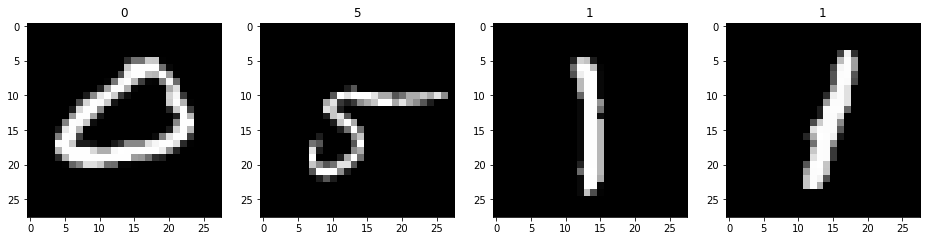

In [9]:
# display some samples
num_display_samples = 4
images, labels = mnist.train.next_batch(num_display_samples)
images = images.reshape((num_display_samples, 28, 28, 1))
f, axarr = plt.subplots(1, num_display_samples, figsize=(4*num_display_samples,4))
for i in range(num_display_samples):
    axarr[i].imshow(np.squeeze(images[i,:,:,:]), cmap="gray")
    axarr[i].set_title(labels[i])
plt.show()

**Build the model:**

In [10]:
config["use_sample"] = True
tf.reset_default_graph()
out = model(config, train_cfg, reuse_core=False, reuse_action=False)
images_ph, labels_ph, hybrid_loss, J, cross_ent, b_mse, r_avg, correct_num, lr, train_step, loc_means, loc_samples = out

**Train the model:** 

* You should reach <span style="color:red">90%</span> validation & test acc in this experiment.
* This network may be sentitive to its init weigths.
* Overfitting may happen during training.

## Note
to avoid overfitting, I change the model saving part to the following structure, that is whenever the validation accuracy is over 90%, save the model. And if a even higher accuracy occurs, override the former model with the new one.

In [12]:
# train
M = train_cfg["M"]
num_epochs = train_cfg["num_epochs"]
num_steps_per_epoch = train_cfg["num_train"] // train_cfg["batch_size"]
eval_size = train_cfg["eval_size"]
# save
saver = tf.train.Saver()
best_acc = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs):
        #####################################
        #           training phase          #
        #####################################
        for i in range(num_steps_per_epoch):
            images, labels = mnist.train.next_batch(train_cfg["batch_size"])
            images = images.reshape((train_cfg["batch_size"], 28, 28, 1))
            # Monte Carlo Estimation: duplicate M times, see Eqn (1) and (2) in paper
            images = np.tile(images, [M, 1, 1, 1])
            labels = np.tile(labels, [M])
            # training
            train_loss, train_J, train_ent, train_bmse, train_r, train_lr, _ = sess.run([hybrid_loss, J, cross_ent, b_mse, r_avg, lr, train_step],
                                                   feed_dict={images_ph: images,labels_ph: labels})
            # report progress
            if i and i % 500 == 0:
                print("epoch {} step {}: lr = {:.5f}\treward = {:.4f}\tloss = {:.4f}".
                      format(e+1, i, train_lr, train_r, train_loss))
                print("epoch {} step {}: J = {:.5f}\tcross_ent = {:.4f}\tbaseline_mse = {:.4f}".
                      format(e+1, i, train_J, train_ent, train_bmse))
                
        #####################################
        #         evaluation phase          #
        #####################################
        # validation set
        val_correct_num = 0.0
        for i in range(mnist.validation.num_examples//eval_size):
            images, labels = mnist.validation.next_batch(eval_size)
            images = images.reshape((eval_size, 28, 28, 1))
            
            val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        val_acc = val_correct_num/mnist.validation.num_examples
        print("------epoch {}: val_acc = {:.4f}".format(e+1, val_acc))
        if val_acc>best_acc:
            best_acc = val_acc
            if best_acc>0.9:
                save_path = saver.save(sess, "./tmp/model_28_15.ckpt")
            
    
    #####################################
    #            save model             #
    #####################################
    # Save the variables to disk.
    #if not os.path.exists("./tmp/"):
    #    os.mkdir("./tmp/")
    #save_path = saver.save(sess, "./tmp/model_28_15.ckpt")
    #print("Model saved in file: %s" % save_path)

epoch 1 step 500: lr = 0.00010	reward = 0.3188	loss = 2.1042
epoch 1 step 500: J = 0.01619	cross_ent = 1.9003	baseline_mse = 0.2202
epoch 1 step 1000: lr = 0.00010	reward = 0.4250	loss = 1.6904
epoch 1 step 1000: J = 0.11682	cross_ent = 1.5637	baseline_mse = 0.2435
epoch 1 step 1500: lr = 0.00010	reward = 0.4250	loss = 1.8744
epoch 1 step 1500: J = 0.10235	cross_ent = 1.7433	baseline_mse = 0.2335
------epoch 1: val_acc = 0.4442
epoch 2 step 500: lr = 0.00009	reward = 0.3969	loss = 2.0189
epoch 2 step 500: J = -0.11166	cross_ent = 1.6640	baseline_mse = 0.2432
epoch 2 step 1000: lr = 0.00009	reward = 0.5688	loss = 1.5210
epoch 2 step 1000: J = 0.01883	cross_ent = 1.3048	baseline_mse = 0.2350
epoch 2 step 1500: lr = 0.00009	reward = 0.5063	loss = 1.9020
epoch 2 step 1500: J = -0.19834	cross_ent = 1.4556	baseline_mse = 0.2482
------epoch 2: val_acc = 0.6800
epoch 3 step 500: lr = 0.00009	reward = 0.6969	loss = 1.0470
epoch 3 step 500: J = -0.02436	cross_ent = 0.8227	baseline_mse = 0.1999
e

In [11]:
saver = tf.train.Saver()
# evaluation: output val_acc and test_acc
eval_size = train_cfg["eval_size"]
paths = []
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./tmp/model_28_15.ckpt")
    print("Model restored.")
    # validation set
    val_correct_num = 0.0
    for i in range(mnist.validation.num_examples//eval_size):
        images = mnist.validation.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.validation.labels[i*eval_size:(i+1)*eval_size]
        images = images.reshape((eval_size, 28, 28, 1))

        val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
    val_acc = val_correct_num/mnist.validation.num_examples
    print("val_acc = {:.4f}".format(val_acc))

    # test set
    test_correct_num = 0.0
    for i in range(mnist.test.num_examples//eval_size):
        images = mnist.test.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.test.labels[i*eval_size:(i+1)*eval_size]
        images = images.reshape((eval_size, 28, 28, 1))

        test_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        paths.append(sess.run(loc_samples, feed_dict={images_ph: images,labels_ph: labels}))
    test_acc = test_correct_num/mnist.test.num_examples
    print("test_acc = {:.4f}".format(test_acc))   

INFO:tensorflow:Restoring parameters from ./tmp/model_28_15.ckpt
Model restored.
val_acc = 0.9014
test_acc = 0.8958


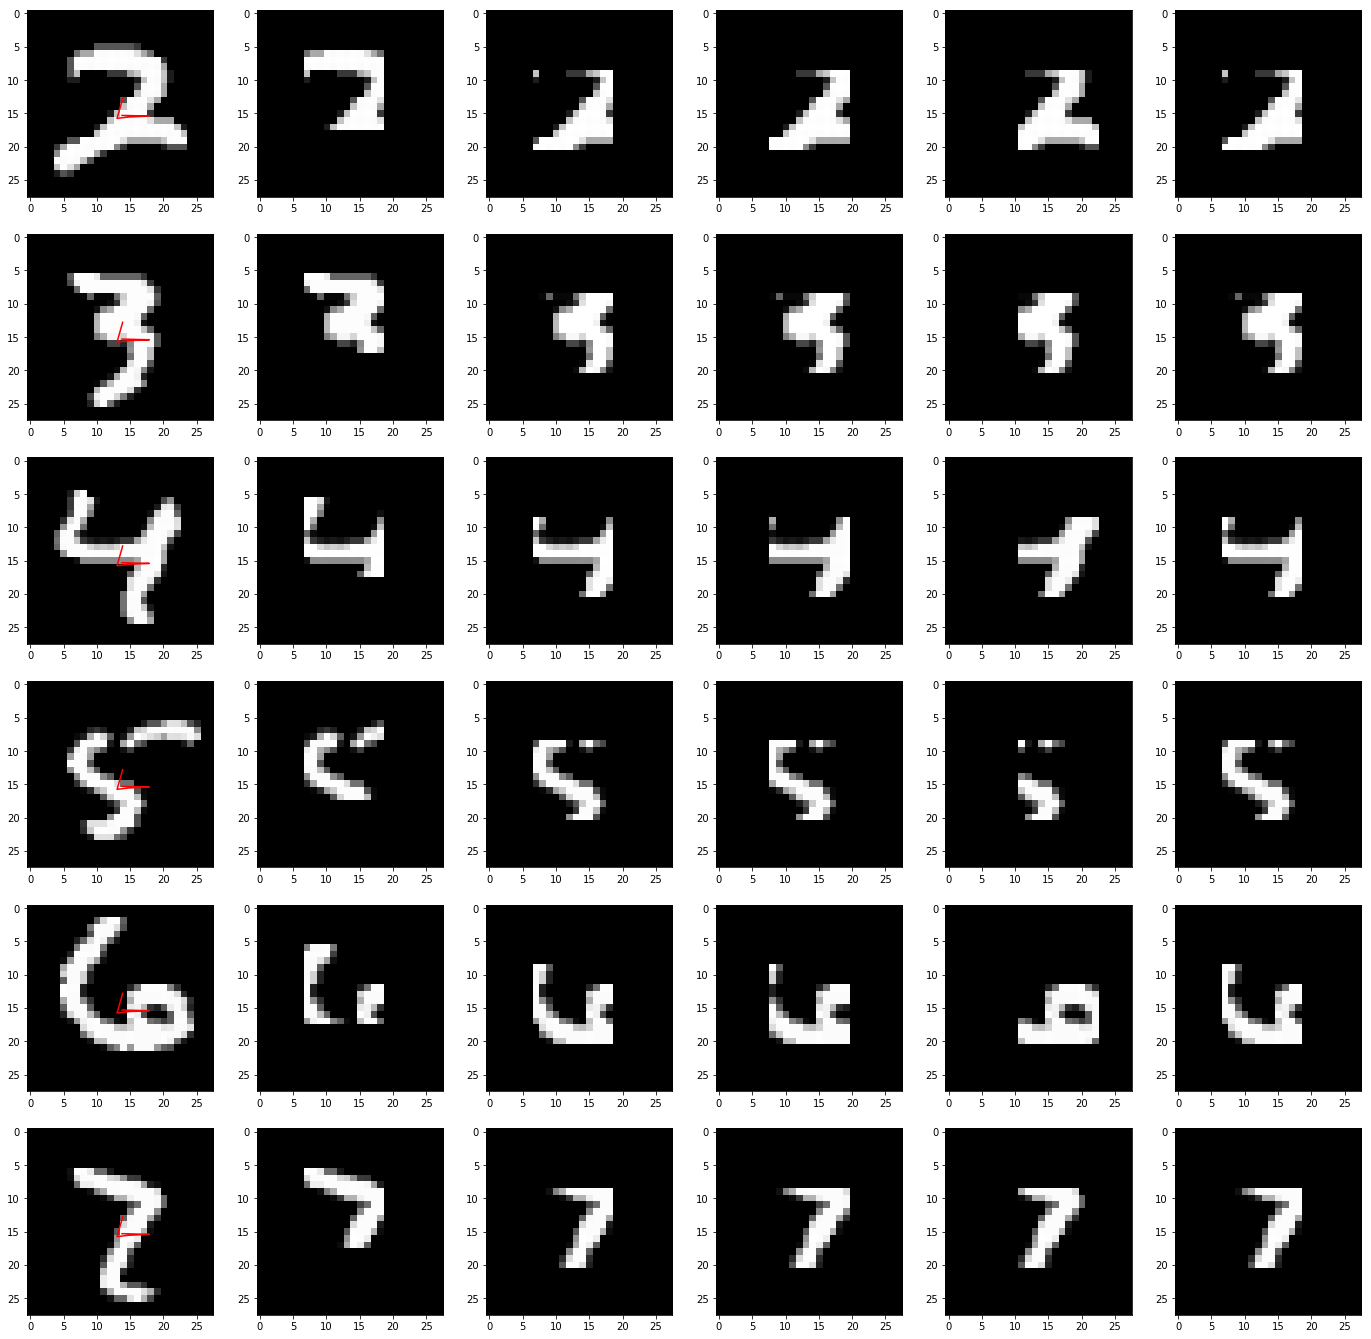

In [16]:
# display the glimpse path. You can use "glimpse_path" or create your own function.
from ecbm4040.ram.utils import glimpse_path

paths = np.asarray(paths).reshape([-1, config["num_glimpses"], config["loc_dim"]])
glimpse_path(images, paths[0:5, :, :], config["glimpse_win"], config["glimpse_scale"])

### Translated 60x60 MNIST

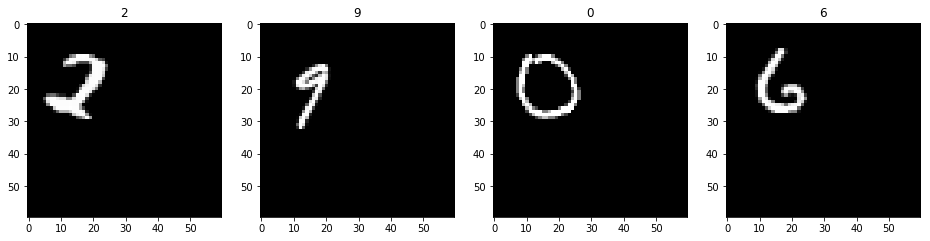

In [9]:
from ecbm4040.ram.utils import translate_60_mnist

# display some translated samples: all samples in one batch share the same translation transform.
num_display_samples = 4
images, labels = mnist.train.next_batch(num_display_samples)
images = translate_60_mnist(images, image_size=28, num_channels=1)
f, axarr = plt.subplots(1, num_display_samples, figsize=(4*num_display_samples,4))
for i in range(num_display_samples):
    axarr[i].imshow(np.squeeze(images[i,:,:,:]), cmap="gray")
    axarr[i].set_title(labels[i])
plt.show()

**Train the model:** set a larger glimpse window and add more scales.

In [13]:
# TODO: train
config["image_size"] = 60
config["glimpse_win"] = 15
config["glimpse_scale"] = 3
train_cfg["num_epochs"] = 25
tf.reset_default_graph()
out = model(config, train_cfg, reuse_core=False, reuse_action=False)
images_ph, labels_ph, hybrid_loss, J, cross_ent, b_mse, r_avg, correct_num, lr, train_step, loc_means, loc_samples = out

In [14]:
M = train_cfg["M"]
num_epochs = train_cfg["num_epochs"]
num_steps_per_epoch = train_cfg["num_train"] // train_cfg["batch_size"]
eval_size = train_cfg["eval_size"]
# save
saver = tf.train.Saver()
best_acc = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs):
        #####################################
        #           training phase          #
        #####################################
        for i in range(num_steps_per_epoch):
            images, labels = mnist.train.next_batch(train_cfg["batch_size"])
            images = translate_60_mnist(images, image_size=28, num_channels=1)
            images = images.reshape((train_cfg["batch_size"], 60, 60, 1))
            # Monte Carlo Estimation: duplicate M times, see Eqn (1) and (2) in paper
            images = np.tile(images, [M, 1, 1, 1])
            labels = np.tile(labels, [M])
            # training
            train_loss, train_J, train_ent, train_bmse, train_r, train_lr, _ = sess.run([hybrid_loss, J, cross_ent, b_mse, r_avg, lr, train_step],
                                                   feed_dict={images_ph: images,labels_ph: labels})
            # report progress
            if i and i % 500 == 0:
                print("epoch {} step {}: lr = {:.5f}\treward = {:.4f}\tloss = {:.4f}".
                      format(e+1, i, train_lr, train_r, train_loss))
                print("epoch {} step {}: J = {:.5f}\tcross_ent = {:.4f}\tbaseline_mse = {:.4f}".
                      format(e+1, i, train_J, train_ent, train_bmse))
                
        #####################################
        #         evaluation phase          #
        #####################################
        # validation set
        val_correct_num = 0.0
        for i in range(mnist.validation.num_examples//eval_size):
            images, labels = mnist.validation.next_batch(eval_size)
            images = translate_60_mnist(images, image_size=28, num_channels=1)
            images = images.reshape((eval_size, 60, 60, 1))
            
            val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        val_acc = val_correct_num/mnist.validation.num_examples
        print("------epoch {}: val_acc = {:.4f}".format(e+1, val_acc))
        if val_acc>best_acc:
            best_acc = val_acc
            save_path = saver.save(sess, "./tmp/model_60_15.ckpt")

epoch 1 step 500: lr = 0.00010	reward = 0.2438	loss = 2.2296
epoch 1 step 500: J = -0.01309	cross_ent = 2.0373	baseline_mse = 0.1792
epoch 1 step 1000: lr = 0.00010	reward = 0.2125	loss = 2.2336
epoch 1 step 1000: J = -0.07369	cross_ent = 2.0091	baseline_mse = 0.1508
epoch 1 step 1500: lr = 0.00010	reward = 0.3281	loss = 1.8667
epoch 1 step 1500: J = 0.01887	cross_ent = 1.7155	baseline_mse = 0.1701
------epoch 1: val_acc = 0.2884
epoch 2 step 500: lr = 0.00009	reward = 0.2656	loss = 1.9236
epoch 2 step 500: J = -0.05016	cross_ent = 1.7098	baseline_mse = 0.1636
epoch 2 step 1000: lr = 0.00009	reward = 0.4813	loss = 1.4722
epoch 2 step 1000: J = 0.03271	cross_ent = 1.3582	baseline_mse = 0.1467
epoch 2 step 1500: lr = 0.00009	reward = 0.2938	loss = 1.9174
epoch 2 step 1500: J = -0.07024	cross_ent = 1.6852	baseline_mse = 0.1620
------epoch 2: val_acc = 0.3670
epoch 3 step 500: lr = 0.00009	reward = 0.4188	loss = 1.7979
epoch 3 step 500: J = 0.01284	cross_ent = 1.5985	baseline_mse = 0.2122


------epoch 19: val_acc = 0.6196
epoch 20 step 500: lr = 0.00004	reward = 0.6438	loss = 1.0986
epoch 20 step 500: J = 0.16570	cross_ent = 1.0520	baseline_mse = 0.2123
epoch 20 step 1000: lr = 0.00004	reward = 0.5000	loss = 1.8894
epoch 20 step 1000: J = -0.26434	cross_ent = 1.4105	baseline_mse = 0.2145
epoch 20 step 1500: lr = 0.00004	reward = 0.7594	loss = 0.7373
epoch 20 step 1500: J = 0.01723	cross_ent = 0.5952	baseline_mse = 0.1593
------epoch 20: val_acc = 0.6224
epoch 21 step 500: lr = 0.00004	reward = 0.6125	loss = 0.3618
epoch 21 step 500: J = 0.75043	cross_ent = 0.8940	baseline_mse = 0.2182
epoch 21 step 1000: lr = 0.00004	reward = 0.7750	loss = 0.9189
epoch 21 step 1000: J = -0.15397	cross_ent = 0.6190	baseline_mse = 0.1460
epoch 21 step 1500: lr = 0.00004	reward = 0.6656	loss = 0.6102
epoch 21 step 1500: J = 0.38922	cross_ent = 0.8105	baseline_mse = 0.1889
------epoch 21: val_acc = 0.6926
epoch 22 step 500: lr = 0.00003	reward = 0.7938	loss = 1.3132
epoch 22 step 500: J = -0

In [15]:
# TODO: evaluation, output val_acc and test_acc
saver = tf.train.Saver()
# evaluation: output val_acc and test_acc
eval_size = train_cfg["eval_size"]
paths = []
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./tmp/model_60_15.ckpt")
    print("Model restored.")
    # validation set
    val_correct_num = 0.0
    for i in range(mnist.validation.num_examples//eval_size):
        images = mnist.validation.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.validation.labels[i*eval_size:(i+1)*eval_size]
        images = translate_60_mnist(images, image_size=28, num_channels=1)
        images = images.reshape((eval_size, 60, 60, 1))
        
        val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
    val_acc = val_correct_num/mnist.validation.num_examples
    print("val_acc = {:.4f}".format(val_acc))

    # test set
    test_correct_num = 0.0
    for i in range(mnist.test.num_examples//eval_size):
        images = mnist.test.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.test.labels[i*eval_size:(i+1)*eval_size]
        images = translate_60_mnist(images, image_size=28, num_channels=1)
        images = images.reshape((eval_size, 60, 60, 1))

        test_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        paths.append(sess.run(loc_samples, feed_dict={images_ph: images,labels_ph: labels}))
    test_acc = test_correct_num/mnist.test.num_examples
    print("test_acc = {:.4f}".format(test_acc))   

INFO:tensorflow:Restoring parameters from ./tmp/model_60_15.ckpt
Model restored.
val_acc = 0.7584
test_acc = 0.7346


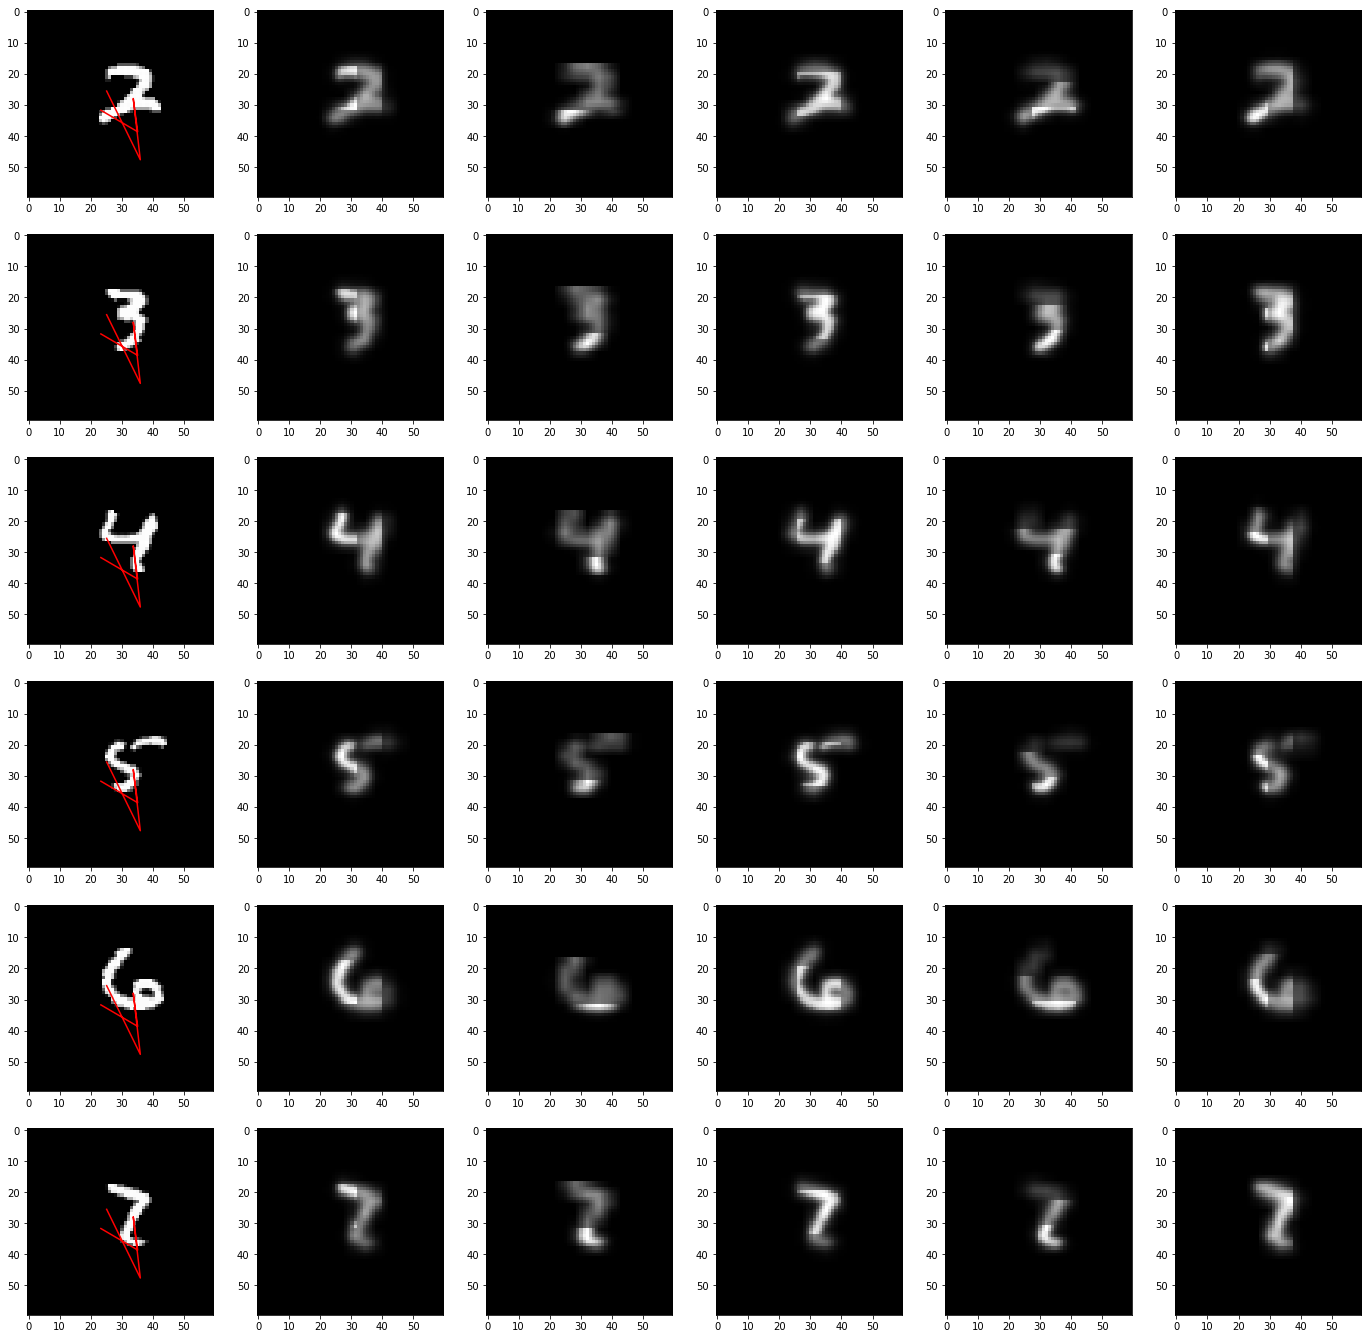

In [16]:
# TODO: display the glimpse path and glimpse patches.
from ecbm4040.ram.utils import glimpse_path

paths = np.asarray(paths).reshape([-1, config["num_glimpses"], config["loc_dim"]])
glimpse_path(images, paths[0:5, :, :], config["glimpse_win"], config["glimpse_scale"])

### MNIST pair addition (Optional)

In this experiment, the task is to predict the sum of a pair of digits. So, remember to change the "num_classes" into 19. Note that running this experiment may take several hours with GPU.

**Warning:** This experiment is really challenging. Based on previous experiments, it may take many hours to reach only 65% accuracy. So we make this part optional. 

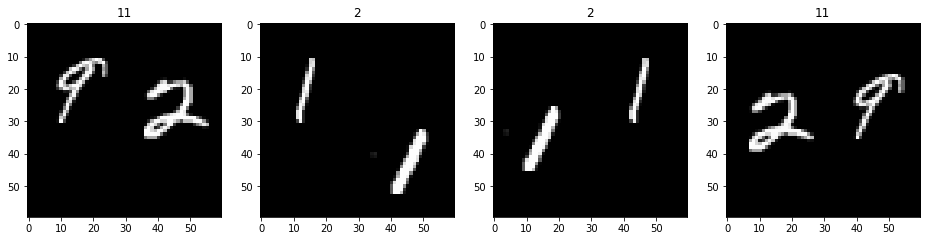

In [17]:
from ecbm4040.ram.utils import mnist_addition_pair

# display some samples: image -- a pair of digit; label -- the sum of two digits.
num_display_samples = 4
images, labels = mnist.train.next_batch(num_display_samples)
images, labels = mnist_addition_pair(images, labels, image_size=28, num_channels=1)
f, axarr = plt.subplots(1, num_display_samples, figsize=(4*num_display_samples,4))
for i in range(num_display_samples):
    axarr[i].imshow(np.squeeze(images[i,:,:,:]), cmap="gray")
    axarr[i].set_title(labels[i])
plt.show()

**train**: may need more glimpse to give the sensor more freedom and **a large enough M** to reduce the variance. 

In [18]:
# TODO: train
config["num_classes"] = 19
config["num_glimpses"] = 12
train_cfg["M"] = 20
tf.reset_default_graph()
out = model(config, train_cfg, reuse_core=False, reuse_action=False)
images_ph, labels_ph, hybrid_loss, J, cross_ent, b_mse, r_avg, correct_num, lr, train_step, loc_means, loc_samples = out

In [19]:
M = train_cfg["M"]
num_epochs = train_cfg["num_epochs"]
num_steps_per_epoch = train_cfg["num_train"] // train_cfg["batch_size"]
eval_size = train_cfg["eval_size"]
# save
saver = tf.train.Saver()
best_acc = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs):
        #####################################
        #           training phase          #
        #####################################
        for i in range(num_steps_per_epoch):
            images, labels = mnist.train.next_batch(train_cfg["batch_size"])
            images, labels = mnist_addition_pair(images, labels, image_size=28, num_channels=1)
            images = images.reshape((train_cfg["batch_size"], 60, 60, 1))
            # Monte Carlo Estimation: duplicate M times, see Eqn (1) and (2) in paper
            images = np.tile(images, [M, 1, 1, 1])
            labels = np.tile(labels, [M])
            # training
            train_loss, train_J, train_ent, train_bmse, train_r, train_lr, _ = sess.run([hybrid_loss, J, cross_ent, b_mse, r_avg, lr, train_step],
                                                   feed_dict={images_ph: images,labels_ph: labels})
            # report progress
            if i and i % 500 == 0:
                print("epoch {} step {}: lr = {:.5f}\treward = {:.4f}\tloss = {:.4f}".
                      format(e+1, i, train_lr, train_r, train_loss))
                print("epoch {} step {}: J = {:.5f}\tcross_ent = {:.4f}\tbaseline_mse = {:.4f}".
                      format(e+1, i, train_J, train_ent, train_bmse))
                
        #####################################
        #         evaluation phase          #
        #####################################
        # validation set
        val_correct_num = 0.0
        for i in range(mnist.validation.num_examples//eval_size):
            images, labels = mnist.validation.next_batch(eval_size)
            images, labels = mnist_addition_pair(images, labels, image_size=28, num_channels=1)
            images = images.reshape((eval_size, 60, 60, 1))
            
            val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        val_acc = val_correct_num/mnist.validation.num_examples
        print("------epoch {}: val_acc = {:.4f}".format(e+1, val_acc))
        if val_acc>best_acc:
            best_acc = val_acc
            save_path = saver.save(sess, "./tmp/model_60_2.ckpt")

epoch 1 step 500: lr = 0.00010	reward = 0.0625	loss = 2.8916
epoch 1 step 500: J = -0.05649	cross_ent = 2.7754	baseline_mse = 0.0597
epoch 1 step 1000: lr = 0.00010	reward = 0.0000	loss = 3.2663
epoch 1 step 1000: J = -0.19507	cross_ent = 3.0587	baseline_mse = 0.0126
epoch 1 step 1500: lr = 0.00010	reward = 0.1875	loss = 2.7145
epoch 1 step 1500: J = 0.13195	cross_ent = 2.6883	baseline_mse = 0.1582
------epoch 1: val_acc = 0.0912
epoch 2 step 500: lr = 0.00009	reward = 0.0625	loss = 2.8685
epoch 2 step 500: J = -0.04282	cross_ent = 2.7666	baseline_mse = 0.0591
epoch 2 step 1000: lr = 0.00009	reward = 0.1875	loss = 2.7375
epoch 2 step 1000: J = 0.11317	cross_ent = 2.6943	baseline_mse = 0.1563
epoch 2 step 1500: lr = 0.00009	reward = 0.0000	loss = 2.9653
epoch 2 step 1500: J = -0.16056	cross_ent = 2.7964	baseline_mse = 0.0084
------epoch 2: val_acc = 0.1044
epoch 3 step 500: lr = 0.00009	reward = 0.1844	loss = 2.9349
epoch 3 step 500: J = 0.07290	cross_ent = 2.8553	baseline_mse = 0.1525


------epoch 19: val_acc = 0.1358
epoch 20 step 500: lr = 0.00004	reward = 0.4297	loss = 2.5856
epoch 20 step 500: J = -0.35838	cross_ent = 1.9578	baseline_mse = 0.2694
epoch 20 step 1000: lr = 0.00004	reward = 0.1641	loss = 2.4768
epoch 20 step 1000: J = 0.14183	cross_ent = 2.4847	baseline_mse = 0.1339
epoch 20 step 1500: lr = 0.00004	reward = 0.0344	loss = 2.7305
epoch 20 step 1500: J = -0.02983	cross_ent = 2.6532	baseline_mse = 0.0474
------epoch 20: val_acc = 0.1582
epoch 21 step 500: lr = 0.00004	reward = 0.1203	loss = 2.5895
epoch 21 step 500: J = 0.06435	cross_ent = 2.5482	baseline_mse = 0.1057
epoch 21 step 1000: lr = 0.00004	reward = 0.1609	loss = 2.5695
epoch 21 step 1000: J = -0.03315	cross_ent = 2.3971	baseline_mse = 0.1393
epoch 21 step 1500: lr = 0.00004	reward = 0.2656	loss = 2.3549
epoch 21 step 1500: J = 0.08789	cross_ent = 2.2277	baseline_mse = 0.2151
------epoch 21: val_acc = 0.1662
epoch 22 step 500: lr = 0.00003	reward = 0.1125	loss = 2.8043
epoch 22 step 500: J = -

In [22]:
# TODO: evaluation: output val_acc and test_acc
saver = tf.train.Saver()
# evaluation: output val_acc and test_acc
eval_size = train_cfg["eval_size"]
paths = []
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./tmp/model_60_2.ckpt")
    print("Model restored.")
    # validation set
    val_correct_num = 0.0
    for i in range(mnist.validation.num_examples//eval_size):
        images = mnist.validation.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.validation.labels[i*eval_size:(i+1)*eval_size]
        images, labels = mnist_addition_pair(images, labels, image_size=28, num_channels=1)
        images = images.reshape((eval_size, 60, 60, 1))

        val_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
    val_acc = val_correct_num/mnist.validation.num_examples
    print("val_acc = {:.4f}".format(val_acc))

    # test set
    test_correct_num = 0.0
    for i in range(mnist.test.num_examples//eval_size):
        images = mnist.test.images[i*eval_size:(i+1)*eval_size]
        labels = mnist.test.labels[i*eval_size:(i+1)*eval_size]
        images, labels = mnist_addition_pair(images, labels, image_size=28, num_channels=1)
        images = images.reshape((eval_size, 60, 60, 1))

        test_correct_num += sess.run(correct_num, feed_dict={images_ph: images,labels_ph: labels})
        paths.append(sess.run(loc_samples, feed_dict={images_ph: images,labels_ph: labels}))
    test_acc = test_correct_num/mnist.test.num_examples
    print("test_acc = {:.4f}".format(test_acc))   

INFO:tensorflow:Restoring parameters from ./tmp/model_60_2.ckpt
Model restored.
val_acc = 0.1744
test_acc = 0.1859


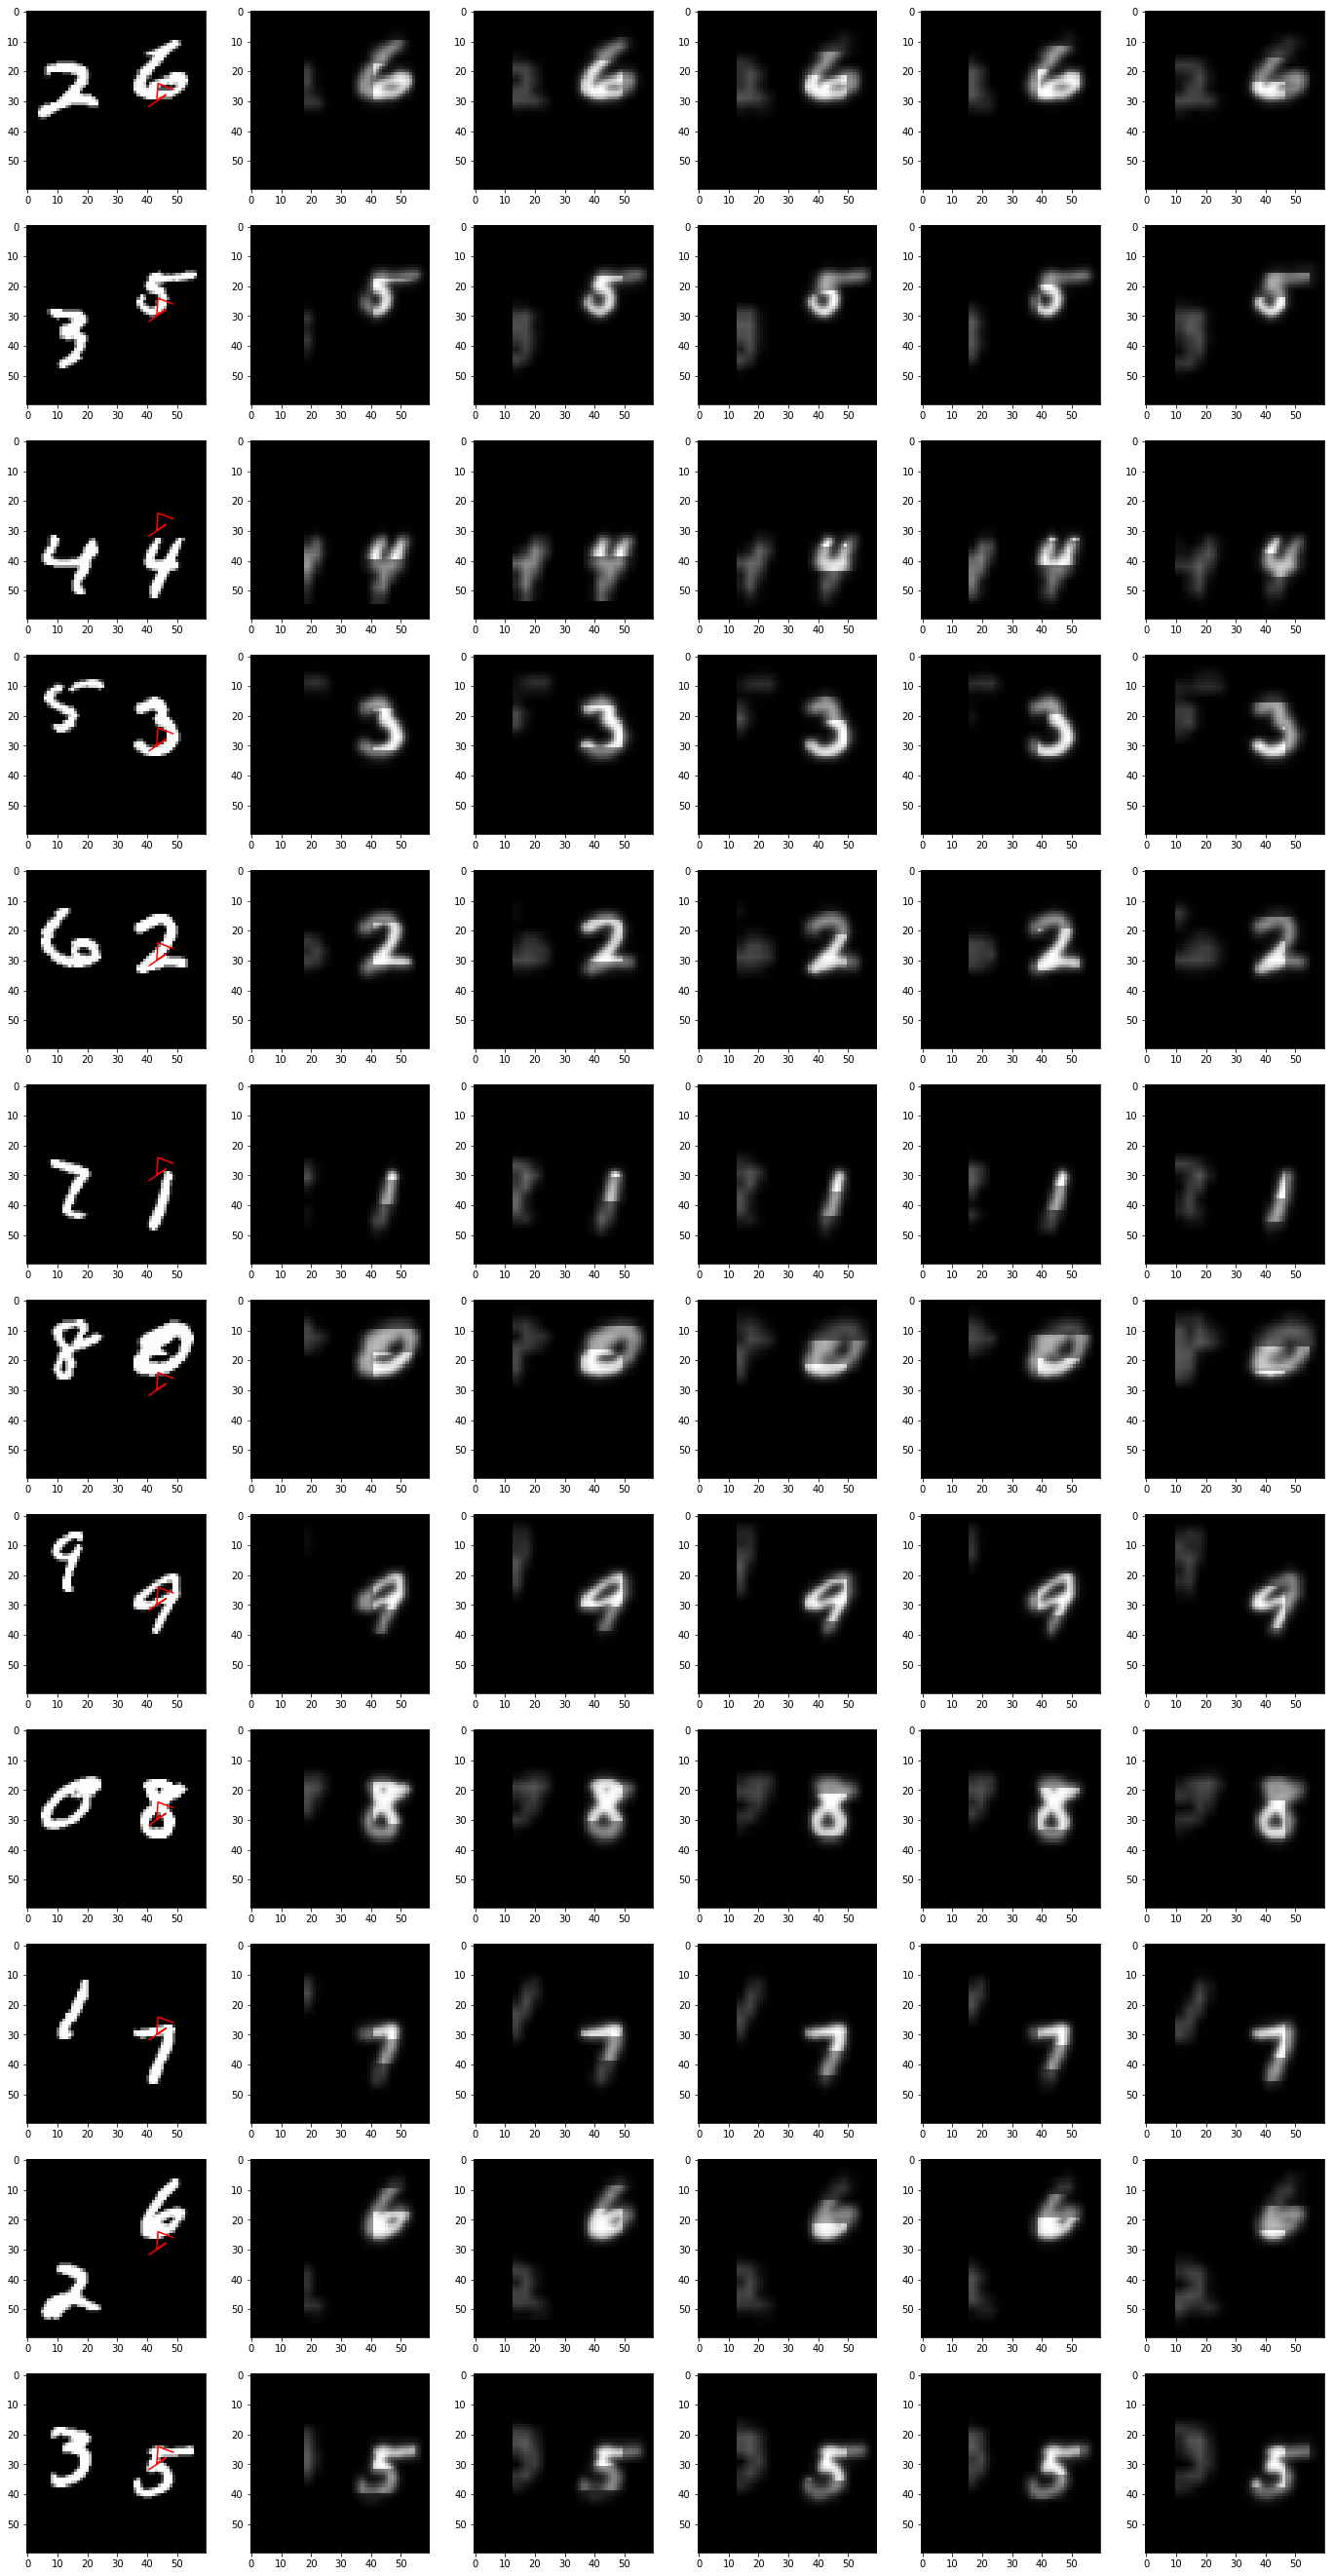

In [23]:
# TODO: display the glimpse path and glimpse patches.
from ecbm4040.ram.utils import glimpse_path

paths = np.asarray(paths).reshape([-1, config["num_glimpses"], config["loc_dim"]])
glimpse_path(images, paths[0:5, :, :], config["glimpse_win"], config["glimpse_scale"])

## Other recommended reading

[1] [Multiple object recognition with visual attention](https://arxiv.org/pdf/1412.7755.pdf)